<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Add-LPA" data-toc-modified-id="Add-LPA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Add LPA</a></span></li><li><span><a href="#feed-into-linear-model-an-ensemble" data-toc-modified-id="feed-into-linear-model-an-ensemble-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>feed into linear model an ensemble</a></span></li></ul></div>

In [1]:
# from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
import keras.backend as K

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
####################################
# Define the max length of the text
####################################
max_length = 500


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('sample_0.1.csv')


In [4]:
import seaborn as sns
df['len_1'] = df['text_1'].apply(lambda x: len(x))
df['len_2'] = df['text_2'].apply(lambda x: len(x))
df['len_1'].describe(),df['len_2'].describe()


(count     5224.000000
 mean     11675.117534
 std       1100.101609
 min       9717.000000
 25%      11303.750000
 50%      11616.000000
 75%      11925.000000
 max      65796.000000
 Name: len_1, dtype: float64,
 count      5224.000000
 mean      11678.908882
 std        1455.235206
 min        9885.000000
 25%       11310.000000
 50%       11605.500000
 75%       11941.000000
 max      101196.000000
 Name: len_2, dtype: float64)

Text(0.5, 0.98, 'Text Length')

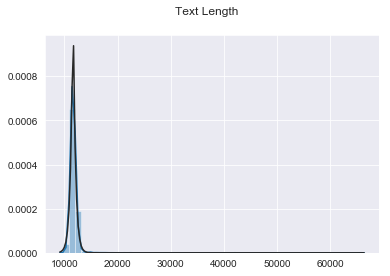

In [5]:
# df['len_2'].hist(bins=10, grid=True)
from scipy import stats 
sns.set_style('darkgrid')
sns.distplot(df[['len_1']], fit=stats.laplace)
plt.suptitle('Text Length')



11616.0

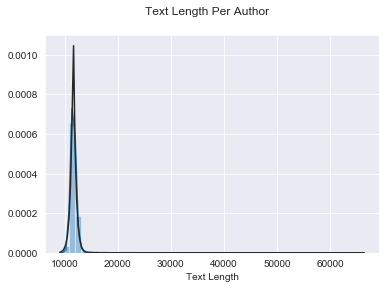

In [6]:
import ast
df['author_1'] = df['authors'].apply(lambda x: ast.literal_eval(x)[0] )
sns.set_style('darkgrid')
sns.distplot(df.groupby(['author_1']).mean()['len_1'], fit=stats.laplace)
plt.suptitle('Text Length Per Author')
plt.xlabel('Text Length')

df.groupby(['author_1']).mean()['len_1'].median()

In [7]:
df['same'].mean(), df.shape


(0.5342649310872895, (5224, 10))

In [8]:
# sample_df = df.sample(n=5000)

In [9]:
# sample_df['same'] = sample_df['same'].astype(int)
# sample_df['same'].mean()

In [10]:
pairs = pd.read_csv('pairs_distances.csv')
pairs.head()
df_with_distance = df.merge(pairs[['text_id_1','text_id_2','distance']],
        how='inner',
        left_on=['text_id_1','text_id_2'],
        right_on= ['text_id_1','text_id_2'])


In [11]:
# df_with_distance.groupby().head()
df_with_distance.groupby(by = 'same').mean()['distance']

same
False    1.479674
True     1.440751
Name: distance, dtype: float64

same
False    1.479674
True     1.440751
Name: distance, dtype: float64
same
False    0.290205
True     0.308694
Name: distance, dtype: float64


c:\users\212778050\pycharmprojects\predict-sr-based-on-syslog\deploy_model\env_deployment\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


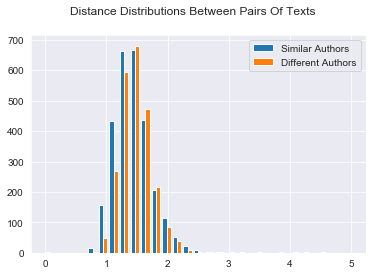

In [12]:
# see difference between distances of texts that are similar and not
print(df_with_distance.groupby('same').mean()['distance'])
print(df_with_distance.groupby('same').std()['distance'])


group1 = df_with_distance[df_with_distance['same']==True]['distance']
# group1.hist()
# plt.show()
group2 = df_with_distance[df_with_distance['same']==False]['distance']
# group2.hist()
# plt.show()
bins = np.linspace(0, 5, 30)
plt.hist([group1, group2], bins, label=['Similar Authors', 'Different Authors'])
plt.legend(loc='upper right')
plt.suptitle('Distance Distributions Between Pairs Of Texts')
plt.show()

Permutation Test

In [13]:
# import scipy.stats as stats
# stats.ttest_ind(a=group1, b=group2, equal_var=True)

# from  sklearn.model_selection import permutation_test_score
# permutation_test_score()

import random 
len1 = len(group1)
len2 = len(group2)
# random partitions
observed_diff  =  group1.mean() - group2.mean()

conc = group1.append(group2).reset_index(drop=True)
conc
# ind_vec <- sample(1:(n.A + n.B), n.A)

B  = 10000
rand_means_diff =  []
for i in range(B):
    ind_vec = random.sample(range(len(conc)), len1)
    rand_means_diff.append(conc.loc[conc.index.isin(ind_vec)].mean() - conc.loc[~conc.index.isin(ind_vec)].mean())

   
rand_p_val =  abs(pd.DataFrame(rand_means_diff) ) >= abs(observed_diff)
rand_p_val


,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


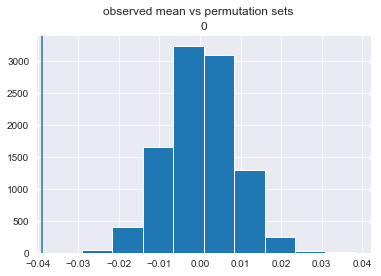

In [14]:
pd.DataFrame(rand_means_diff).hist()
plt.axvline(observed_diff)
plt.suptitle('observed mean vs permutation sets')
plt.savefig('images_and_reports/permutation_test.jpeg'.format(max_length))

plt.show()

In [15]:
#max_length = sample_df.pair.apply(lambda x: len(x.split())).max()



# # get sample of N articles with distance
# sample_df_with_distance = df_with_distance.iloc[sample_df.index]
sample_df_with_distance = df_with_distance


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sample_df_with_distance['pair'])
sample_df_with_distance['tokenized_text_1'] = tokenizer.texts_to_sequences(sample_df_with_distance['text_1'])
sample_df_with_distance['tokenized_text_2'] = tokenizer.texts_to_sequences(sample_df_with_distance['text_2'])
sample_df_with_distance['tokenized_text_1'] = list(pad_sequences(sample_df_with_distance['tokenized_text_1'], 
                                                                 maxlen = max_length, padding='post'))
sample_df_with_distance['tokenized_text_2'] = list(pad_sequences(sample_df_with_distance['tokenized_text_2'], 
                                                                 maxlen = max_length, padding='post'))

# vocab_size = max(max([max(sublist) for sublist in df['tokenized_text_1'].values])+1 , max([max(sublist) for sublist in df['tokenized_text_2'].values])+1 )
vocab_size = len(tokenizer.word_index.items())+1
vocab_size

164997

In [16]:
import numpy as np
embeddings_index = dict()
f = open('../../glove/glove.6B.50d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
len(tokenizer.word_index.items()),vocab_size
vocab_size = len(tokenizer.word_index.items())+1


In [18]:
vocab_size

164997

In [19]:
embedding_matrix = np.zeros((vocab_size, 50))
print(len(tokenizer.word_index.items()))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix

164996


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.68046999, -0.039263  ,  0.30186   , ..., -0.073297  ,
        -0.064699  , -0.26043999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve


X_train, X_test, y_train, y_test = train_test_split(sample_df_with_distance[['tokenized_text_1',
                                                                             'tokenized_text_2',
                                                                             'distance']], 
                                                    sample_df_with_distance['same'],
                                                    test_size=0.2 , random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, random_state=1)


X_train.shape , X_test.shape , X_val.shape

((3134, 3), (1045, 3), (1045, 3))

In [21]:
len(X_train.iloc[1][0])

500

In [ ]:
from keras.models import Sequential, Model 
from keras.layers import Dense, Embedding, Dropout, LSTM, Concatenate , Reshape , Activation , Input, GlobalMaxPool1D, concatenate , BatchNormalization
from tensorflow.keras.layers import Subtract ,Flatten 
from tensorflow.keras.optimizers import Adam , SGD
from keras.layers import LeakyReLU , Dot , dot
from keras.layers import Lambda
from keras.regularizers import l2
from sklearn.utils import class_weight

import keras.backend as K
from keras.layers import Lambda

def squared_differences(pair_of_tensors):
    x, y = pair_of_tensors
    return K.square(x - y)



# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
print(weights)
# create a eneric embedding layer model 
def create_model(vocab_size,max_length,embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, weights=[embedding_matrix], input_length = max_length))
    model.add(Bidirectional(LSTM(32, 
                   return_sequences=False,
                   dropout=0.1,
                   recurrent_dropout=0.3,
                   kernel_regularizer=l2(0.1), 
                   recurrent_regularizer=l2(0.1), 
                   bias_regularizer=l2(0.1))))
    model.add(BatchNormalization(momentum=0.2))
    model.add(Dense(32, kernel_regularizer=l2(0.1), bias_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    
    return model

t1 = create_model(vocab_size,max_length,embedding_matrix)
t2 = create_model(vocab_size,max_length,embedding_matrix)

# combinedInput = concatenate([t1.output, t2.output])
# combinedInput = dot([t1.output, t1.output],axes=1, normalize=True)

# squared difference option
square_diff = Lambda(squared_differences)([t1.output, t2.output])
x = Dense(2,
          kernel_regularizer=l2(0.5),
          bias_regularizer=l2(0.5))(square_diff)


# x = Dense(16,
#           kernel_regularizer=l2(0.5),
#           bias_regularizer=l2(0.5))(combinedInput)
# x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization(momentum=0.2)(x)
# x = Dense(8, bias_regularizer=l2(1))(x)
# x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[t1.input, t2.input], outputs=x)
opt = Adam(lr=0.00001, decay=0.0015 )
# opt = SGD(lr=0.0001, decay=1e-2 )
model.compile(loss="binary_crossentropy", optimizer=opt,metrics = ['binary_accuracy'])




# train the model
print("[INFO] training model...")
history = model.fit(
    x=[np.stack(X_train['tokenized_text_1'], axis=0),
       np.stack(X_train['tokenized_text_2'], axis=0)],
    y=y_train,
    validation_data=([np.stack(X_val['tokenized_text_1'], axis=0),
                       np.stack(X_val['tokenized_text_2'], axis=0)], y_test),
    epochs=20,
    batch_size=256,
    class_weight=weights
    )





[1.06237288 0.94454491]
[INFO] training model...
Train on 3134 samples, validate on 1045 samples
Epoch 1/20
3134/3134 [==============================] - 232s 74ms/step - loss: 67.7748 - binary_accuracy: 0.5038 - val_loss: 65.9238 - val_binary_accuracy: 0.5330
Epoch 2/20
3134/3134 [==============================] - 241s 77ms/step - loss: 67.6887 - binary_accuracy: 0.5144 - val_loss: 65.8603 - val_binary_accuracy: 0.5416
Epoch 3/20
3134/3134 [==============================] - 248s 79ms/step - loss: 67.5128 - binary_accuracy: 0.5099 - val_loss: 65.7589 - val_binary_accuracy: 0.5359
Epoch 4/20
3134/3134 [==============================] - 256s 82ms/step - loss: 67.5426 - binary_accuracy: 0.4949 - val_loss: 65.6723 - val_binary_accuracy: 0.5416
Epoch 5/20
1280/3134 [===========>..................] - ETA: 2:32 - loss: 67.2308 - binary_accuracy: 0.5172

In [ ]:
metric = 'binary_accuracy'

acc = history.history[metric]
val_acc = history.history['val_{}'.format(metric)]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
preds = model.predict([np.stack(X_test['tokenized_text_1'], axis=0),
                               np.stack(X_test['tokenized_text_2'], axis=0)])
preds

y_classes = preds>0.5
y_test.mean(), y_classes.mean()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_classes))


report = classification_report(y_test, y_classes,output_dict=True)
pd.DataFrame(report).transpose().to_csv('images_and_reports/classification_report_{}_lstm.csv'.format(max_length))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate scores
auc = roc_auc_score(y_test, preds)
# summarize scores
print('ROC AUC=%.3f' % (auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Initial benchmark - RNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
plt.savefig('images_and_reports/roc_{}_lstm.jpeg'.format(max_length))
pyplot.show()



# Add LPA

In [ ]:
pairs.shape , df.shape

In [ ]:

# df_with_distance = df.merge(pairs[['id_1','id_2','distance']],
#         how='inner',
#         left_on=['id_1','id_2'],
#         right_on= ['id_1','id_2'])


# # get sample of N articles with distance
# sample_df_with_distance = df_with_distance.iloc[sample_df.index]

# sample_df_with_distance['tokenized_text_1'] = tokenizer.texts_to_sequences(sample_df_with_distance['text_1'])
# sample_df_with_distance['tokenized_text_2'] = tokenizer.texts_to_sequences(sample_df_with_distance['text_2'])
# sample_df_with_distance['tokenized_text_1'] = list(pad_sequences(sample_df_with_distance['tokenized_text_1'], maxlen = max_length, padding='post'))
# sample_df_with_distance['tokenized_text_2'] = list(pad_sequences(sample_df_with_distance['tokenized_text_2'], maxlen = max_length, padding='post'))

# # vocab_size = max(max([max(sublist) for sublist in df['tokenized_text_1'].values])+1 , max([max(sublist) for sublist in df['tokenized_text_2'].values])+1 )
# vocab_size = len(tokenizer.word_index.items())+1
# vocab_size



In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(sample_df_with_distance[['tokenized_text_1',
#                                                                              'tokenized_text_2',
#                                                                              'distance']], 
#                                                     sample_df_with_distance['same'],
#                                                     test_size=0.2 , random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                   test_size=0.25, random_state=1)

# X_train.shape , X_test.shape , X_val.shape

In [ ]:
# create a eneric embedding layer model 
def create_model(vocab_size,max_length,embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, weights=[embedding_matrix], input_length = max_length))
    model.add(Bidirectional(LSTM(32, 
                   return_sequences=False,
                   dropout=0.1,
                   recurrent_dropout=0.3,
                   kernel_regularizer=l2(0.01), 
                   recurrent_regularizer=l2(0.01), 
                   bias_regularizer=l2(0.001))))
    model.add(BatchNormalization(momentum=0.2))
    model.add(Dense(32, kernel_regularizer=l2(0.1), bias_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    
    return model

input_lpa = Input(shape=(1,))
y = Dense(1, activation="relu")(input_lpa)
y = Model(inputs=input_lpa, outputs=y)


t1 = create_model(vocab_size,max_length,embedding_matrix)
t2 = create_model(vocab_size,max_length,embedding_matrix)


square_diff = Lambda(squared_differences)([t1.output, t2.output])
x = Dense(2,
          kernel_regularizer=l2(0.5),
          bias_regularizer=l2(0.5))(square_diff)



# combinedInput = concatenate([t1.output, t2.output])
# x = Dense(16,
#           kernel_regularizer=l2(0.5),
#           bias_regularizer=l2(0.5))(combinedInput)
# x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization(momentum=0.2)(x)
x = Dense(2)(x)
x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(0.2)(x)
print(x),print(y)

combinedInput_2 = concatenate([x, y.output])
# combinedInput_2 = Lambda(squared_differences)([x, y.output])


last_lyr = Dense(1, activation="sigmoid")(combinedInput_2)

model_2 = Model(inputs=[t1.input, t2.input,y.input], outputs=last_lyr)
opt = Adam(lr=0.0000001, decay=0.0015 )
# opt = SGD(lr=0.0001, decay=1e-2 )
model_2.compile(loss="binary_crossentropy", optimizer=opt,metrics = ['binary_accuracy'])




# train the model
print("[INFO] training model...")
history = model_2.fit(
    x=[np.stack(X_train['tokenized_text_1'], axis=0),
       np.stack(X_train['tokenized_text_2'], axis=0),
       np.stack(X_train['distance'], axis=0)],
    y=y_train,
    validation_data=([np.stack(X_val['tokenized_text_1'], axis=0),
                       np.stack(X_val['tokenized_text_2'], axis=0),
                     np.stack(X_val['distance'], axis=0)], y_test),
    epochs=20,
    batch_size=256,
    class_weight=weights
    )





In [ ]:
metric = 'binary_accuracy'

acc = history.history[metric]
val_acc = history.history['val_{}'.format(metric)]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
preds = model_2.predict([np.stack(X_test['tokenized_text_1'], axis=0),
                       np.stack(X_test['tokenized_text_2'], axis=0),
                       np.stack(X_test['distance'], axis=0)])
preds

y_classes = preds>0.5
y_test.mean(), y_classes.mean()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_classes))

report = classification_report(y_test, y_classes,output_dict=True)
pd.DataFrame(report).transpose().to_csv('images_and_reports/classification_report_{}_encorporated.csv'.format(max_length))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate scores
auc = roc_auc_score(y_test, preds)
# summarize scores
print('ROC AUC=%.3f' % (auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Initial benchmark - RNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
plt.savefig('images_and_reports/roc_{}_encorporated.jpeg'.format(max_length))

pyplot.show()

# feed into linear model an ensemble

In [ ]:
preds = model.predict([np.stack(X_test['tokenized_text_1'], axis=0),
                               np.stack(X_test['tokenized_text_2'], axis=0)])
preds

y_classes = preds>0.5
y_test.mean(), y_classes.mean()

ensemble = pd.DataFrame(X_test['distance'])
ensemble['prev_preds'] = preds
ensemble['y'] = y_test
ensemble

x_train_ens, x_test_ens, y_train_ens, y_test_ens = train_test_split(ensemble[['distance','prev_preds']], 
                                                                    ensemble['y'], test_size=0.25, random_state=0)

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_ens, y_train_ens)

predictions = logisticRegr.predict(x_test_ens)

score = logisticRegr.score(x_test_ens, y_test_ens)
print(score)
print(classification_report(predictions, y_test_ens))



In [ ]:
report = classification_report(predictions, y_test_ens,output_dict=True)
pd.DataFrame(report).transpose().to_csv('images_and_reports/classification_report_{}_stacked.csv'.format(max_length))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# calculate scores
auc = roc_auc_score(y_test_ens, predictions)
# summarize scores
print('ROC AUC=%.3f' % (auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_ens, predictions)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Initial benchmark - RNN')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
plt.savefig('images_and_reports/roc_{}_stacked.jpeg'.format(max_length))

pyplot.show()

In [ ]:

seed = 2
models = []
models.append(('LR', LogisticRegression(tol=0.0001, class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
# models.append(('RF', RandomForestClassifier(n_estimators=10)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model_sel in models:
    kfold = model_selection.KFold(n_splits=15, random_state=seed)
    cv_results = model_selection.cross_val_score(model_sel, 
                                                 ensemble[['distance','prev_preds']],
                                                 ensemble[['y']],
                                                 cv=kfold,
                                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('images_and_reports/model_selection_{}.jpeg'.format(max_length))

plt.show()